In [11]:
from typing import TypedDict, List, Literal
from langchain.prompts import PromptTemplate
from langchain_community.vectorstores import Chroma
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings, ChatNVIDIA
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END
from tavily import TavilyClient
from dotenv import load_dotenv
import os
load_dotenv()

True

In [12]:
os.environ["NVIDIA_API_KEY"] = os.getenv("NVIDIA_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

In [13]:

# Load and prepare documents
loader = PyMuPDFLoader("D:\\Code\\GIt repo\\internship+gen ai\\quadrag\\Hands-on-ML-ml.pdf")
docs = loader.load()
splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=50)
chunks = splitter.split_documents(docs)

vectorstore = Chroma(
    collection_name="hands-on-ml",
    embedding_function=NVIDIAEmbeddings(),
    persist_directory="hands-on-ml1"
)
retriever = vectorstore.as_retriever()

# LLM
llm = ChatNVIDIA(model="mixtral_8x7b")

# State definition
class AgentState(TypedDict):
    question: str
    documents: List[str]
    generation: str
    should_rewrite: bool
    is_hallucination: bool
    answer_meets_question: bool
    route: str


d:\ana\envs\langchain_env\lib\site-packages\langchain_nvidia_ai_endpoints\_statics.py:810: UserWarning: Model mixtral_8x7b is deprecated. Using mistralai/mixtral-8x7b-instruct-v0.1 instead.
  warnings.warn(


In [14]:

prompt = PromptTemplate(
    template="""
    You are Professional Book Reader and you are reading a book called "Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurélien Géron.
    As a reader user I will ask you questions about the book and you will answer them based on the context of the book.
    Here is the context of the book: {context}
    
    Also here is some advice for you:
    1. Always answer the question based on the context of the book.
    2. If the question is not related to the book, say "I don't know".
    3. If the question is not clear, ask for clarification.
    4. You are a professional book reader, so you should answer the question in a professional way also if user needs explanation then explain like a Great Professor of prestigious University explain with Real-world example(s).
    5. If the question is about a specific chapter, mention the chapter number and title in your answer.
    6. If need some Mathematical formula to answer the question then use LaTeX format to write the formula.
    
    Here is the question: {question}
    Answer the question based on the context of the book.
    """,
    input_variables=["context", "question"],
)


rewrite_prompt = PromptTemplate(
    template="Rewrite this question to be more specific:\n{question}",
    input_variables=["question"]
)

hallucination_check_prompt = PromptTemplate(
    template="""
Check if this answer is fully supported by the context.

Context:
{context}

Answer:
{generation}

Reply with: "No Hallucination" or "Hallucination Detected"
""", input_variables=["context", "generation"]
)


In [33]:
query_analysis_prompt = PromptTemplate(
    template="""Analyze the question and determine if it can be answered with the provided context.
Context:{context}
Question: {question}""",
    input_variables=["context", "question"]
)

# Define the query analysis chain
query_analysis_chain = query_analysis_prompt | llm | StrOutputParser()

def query_analysis(state: AgentState) -> AgentState:
    print("🔍 Query Analysis...")
    context = "\n\n".join(doc.page_content for doc in docs[:5])  # Use first few docs for context
    result = query_analysis_chain.invoke({
        "context": context,
        "question": state["question"]
    })
    
    # Route to index search if response indicates question can be answered from book
    return {**state, "route": "index" if "can be answered" in result.lower() else "web"}

In [34]:

# Chains
qa_chain = prompt | llm | StrOutputParser()
rewrite_chain = rewrite_prompt | llm | StrOutputParser()
hallucination_chain = hallucination_check_prompt | llm | StrOutputParser()




def retrieve_docs(state: AgentState) -> AgentState:
    print("📚 Retrieving documents...")
    docs = retriever.invoke(state["question"])
    return {**state, "documents": docs}

def grade_docs(state: AgentState) -> AgentState:
    print("📝 Grading document relevance...")
    return {**state, "should_rewrite": not bool(state["documents"])}

def generate_answer(state: AgentState) -> AgentState:
    print("🧠 Generating book-based answer...")
    context = "\n\n".join(doc.page_content for doc in state["documents"])
    generation = qa_chain.invoke({"context": context, "question": state["question"]})
    return {**state, "generation": generation}

def check_hallucination(state: AgentState) -> AgentState:
    print("🔍 Checking for hallucinations...")
    context = "\n\n".join(doc.page_content for doc in state["documents"])
    result = hallucination_chain.invoke({"context": context, "generation": state["generation"]})
    return {**state, "is_hallucination": "Hallucination Detected" in result}

def check_answers_question(state: AgentState) -> AgentState:
    print("✅ Checking if answer meets question...")
    valid = state["generation"] and "I don't know" not in state["generation"]
    return {**state, "answer_meets_question": valid}

def rewrite_question(state: AgentState) -> AgentState:
    print("🔁 Rewriting question...")
    new_q = rewrite_chain.invoke({"question": state["question"]})
    return {**state, "question": new_q, "should_rewrite": False}



# Conditions
def route_condition(state: AgentState) -> Literal["index", "web"]:
    return state["route"]

def grade_condition(state: AgentState) -> Literal["yes", "no"]:
    return "yes" if not state["should_rewrite"] else "no"

def hallucination_condition(state: AgentState) -> Literal["yes", "no"]:
    return "no" if not state["is_hallucination"] else "yes"

def check_answer_condition(state: AgentState) -> Literal["yes", "no"]:
    return "yes" if state["answer_meets_question"] else "no"


In [35]:
def web_generate(state: AgentState) -> AgentState:
    print("🌐 Generating web-based answer...")
    tavily_client = TavilyClient()  # API key will be taken from environment variable
    try:
        search_results = tavily_client.search(
            query=state["question"],
            search_depth="basic",
            max_results=2
        )
        
        if search_results and len(search_results.get('results', [])) > 0:
            # Extract content from the first few results
            content = []
            for result in search_results['results'][:2]:
                content.append(f"- {result.get('title', '')}: {result.get('content', '')}")
            
            answer = "\n".join(content)
        else:
            answer = "No relevant information found on the web."
            
    except Exception as e:
        print(f"Error during web search: {str(e)}")
        answer = "Sorry, I encountered an error while searching the web."

    return {**state, "generation": answer}

In [36]:

# Graph setup
workflow = StateGraph(AgentState)
workflow.add_node("query_analysis", query_analysis)
workflow.add_node("retrieve", retrieve_docs)
workflow.add_node("grade", grade_docs)
workflow.add_node("generate", generate_answer)
workflow.add_node("hallucination", check_hallucination)
workflow.add_node("check_answer", check_answers_question)
workflow.add_node("rewrite", rewrite_question)
workflow.add_node("web_generate", web_generate)

# Routing
workflow.set_entry_point("query_analysis")
workflow.add_conditional_edges("query_analysis", route_condition, {
    "index": "retrieve",
    "web": "web_generate"
})
workflow.add_edge("web_generate", END)
workflow.add_edge("retrieve", "grade")
workflow.add_conditional_edges("grade", grade_condition, {"yes": "generate", "no": "rewrite"})
workflow.add_edge("rewrite", "retrieve")
workflow.add_edge("generate", "hallucination")
workflow.add_conditional_edges("hallucination", hallucination_condition, {"yes": "generate", "no": "check_answer"})
workflow.add_conditional_edges("check_answer", check_answer_condition, {"yes": END, "no": "rewrite"})

app = workflow.compile()


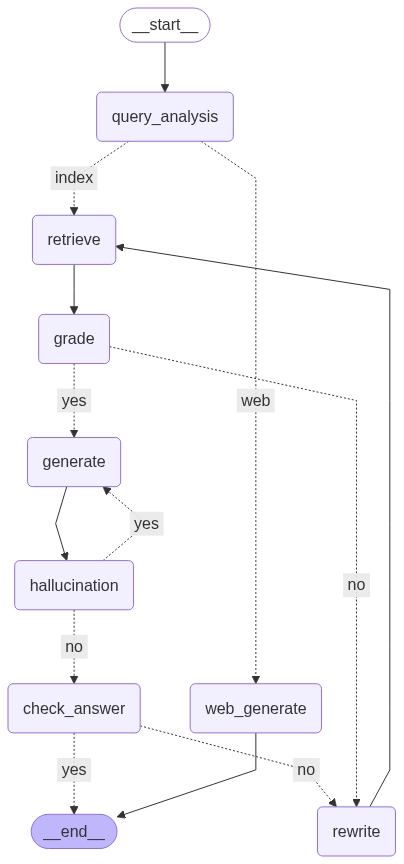

In [37]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [38]:

# Example usage
input_state = {"question": "What is elone muskj?"}
result = app.invoke(input_state)
print("\n📝 Final Answer:\n", result["generation"])



🔍 Query Analysis...
🌐 Generating web-based answer...

📝 Final Answer:
 - Is Elon Musk a US Citizen? Here's What Country the ... - Newsweek: # Is Elon Musk a US Citizen? Billionaire entrepreneur Elon Musk, the CEO of Tesla and SpaceX, has faced renewed scrutiny regarding his citizenship status despite being a U.S. citizen for over two decades. ## Is Elon Musk a Natural-Born U.S. Citizen? No, Elon Musk is not a natural-born American citizen. ## When Did Elon Musk Move to the U.S.? ## When Did Elon Musk Become a U.S. Citizen? ## Why Did Elon Musk Move to the U.S.? ## Are Elon Musk's Children U.S. Citizens? Yes, many of Musk's children are U.S. citizens by birth, as they were born in the United States. While Musk's naturalization as a U.S. citizen is settled, his engagement in federal government affairs raises questions about the role of naturalized citizens in high-level advisory positions.
- Elon Musk - Wikipedia: Bush (2004) * The Good Samaritans: Bono / Bill Gates / Melinda Gates (2005

In [39]:

input_state2 = {"question": "what is the difference between keras and tensorflow?"}
result2 = app.invoke(input_state2)
print("\nfinal Web-Based Answer:\n", result2["generation"])

🔍 Query Analysis...
🌐 Generating web-based answer...

final Web-Based Answer:
 - Difference between TensorFlow and Keras - GeeksforGeeks: Both Tensorflow and Keras are famous machine learning modules used in the field of data science. In this article, we will look at the advantages, disadvantages and the difference between these libraries. TensorFlow . TensorFlow is an open-source platform for machine learning and a symbolic math library that is used for machine learning
- TensorFlow vs Keras: Key Difference Between Them - Guru99: Keras is a Python-based framework that makes it easy to debug and explore. Highly modular neural networks library written in Python; Developed with a focus on allows on fast experimentation; TensorFlow Vs Keras: Difference Between Keras and Tensorflow. Here, are important differences between Keras and Tensorflow


In [40]:

input_state2 = {"question": "wwhat is learning rate in deep learning?"}
result2 = app.invoke(input_state2)
print("\nfinal Web-Based Answer:\n", result2["generation"])

🔍 Query Analysis...
🌐 Generating web-based answer...

final Web-Based Answer:
 - Learning Rate and Its Strategies in Neural Network Training: Learning Rate and Its Strategies in Neural Network Training | by Vrunda Bhattbhatt | The Deep Hub | Medium Learning Rate and Its Strategies in Neural Network Training Learning rate is a critical hyperparameter in the realm of neural network training, playing a central role in the optimization process. However, there is no one-size-fits-all learning rate; it often requires fine-tuning and experimentation, contingent on the specific needs of the training scenario and model architecture. lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.5, staircase=True) optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule) lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9, staircase=False) optimizer = tf.keras.opt

In [41]:

input_state2 = {"question": "wwhat is linear regression?"}
result2 = app.invoke(input_state2)
print("\nfinal Web-Based Answer:\n", result2["generation"])

🔍 Query Analysis...
🌐 Generating web-based answer...

final Web-Based Answer:
 - Linear regression - Wikipedia: Contents Linear regression Part of a series on Regression analysis Models Linear regressionSimple regressionPolynomial regressionGeneral linear model Generalized linear modelVector generalized linear modelDiscrete choiceBinomial regressionBinary regressionLogistic regressionMultinomial logistic regressionMixed logitProbitMultinomial probitOrdered logitOrdered probitPoisson Multilevel modelFixed effectsRandom effectsLinear mixed-effects modelNonlinear mixed-effects model Nonlinear regressionNonparametricSemiparametricRobustQuantileIsotonicPrincipal componentsLeast angleLocalSegmented Errors-in-variables Estimation Least squaresLinearNon-linear OrdinaryWeightedGeneralizedGeneralized estimating equation PartialTotalNon-negativeRidge regressionRegularized Least absolute deviationsIteratively reweightedBayesianBayesian multivariateLeast-squares spectral analysis Background Regress